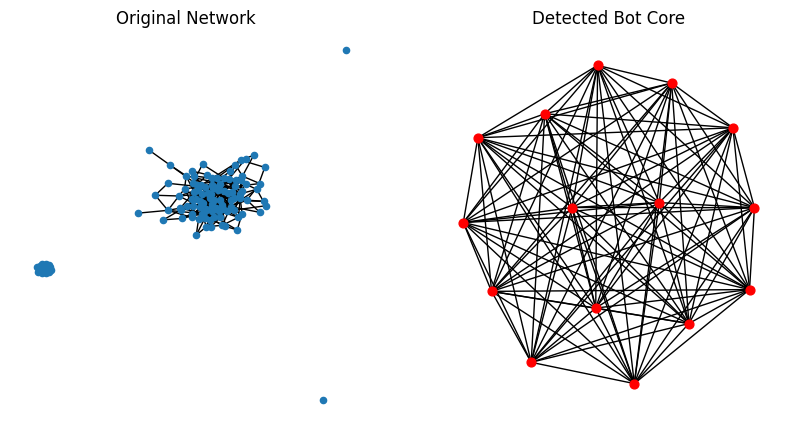

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

# Generating crowd of humans and bots
# Create 100 random humans and 15 bots 
num_humans = 100
num_bots = 15
human_network = nx.erdos_renyi_graph(num_humans, 0.05) # Connected humans graph (each human has a 5% chance of connecting to another)
bot_network = nx.complete_graph(num_bots)            # Bot connections (all bots are connected)
bot_network = nx.relabel_nodes(bot_network, {i: i + num_humans for i in range(num_bots)}) #Assigning nodes to each ID, shifting over so bot IDs don't overlap with human IDs
human_network = nx.compose(human_network, bot_network) # Merging humans and bots together

# LOGIC: The K-Core Pruning Function
def get_k_core(graph, k):

    adj = {node: set(neighbors) for node, neighbors in graph.adjacency()} # Convert to a dictionary adjacency list for speed O(1) lookup time

    while True:
        # Find nodes that have fewer than K neighbors
        to_remove = [node for node, neighbors in adj.items() if len(neighbors) < k]
        
        if not to_remove:
            break 
            
        for node in to_remove:
            # Remove this node from its neighbors' adjacency lists
            for neighbor in adj[node]:
                adj[neighbor].remove(node)
            # Remove the node itself
            del adj[node]
            
    return nx.Graph(adj) # Convert back to NetworkX for visualization

# RUN
bot_core = get_k_core(human_network, k=10)

# VISUALIZE
plt.figure(figsize=(10,5))
plt.subplot(121); nx.draw(human_network, node_size=20); plt.title("Original Network")
plt.subplot(122); nx.draw(bot_core, node_size=40, node_color='red'); plt.title("Detected Bot Core")
plt.show()